# Import Libraries

In [8]:
import torch
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
from torchvision import models, transforms
import warnings
import pickle
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings('ignore')

# Data Preprocessing

In [9]:
data_path = '/Users/maksimtrebusinin/Downloads/flowers'

class_counts = dict()

for class_name in os.listdir(data_path):
    class_dir = os.path.join(data_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

print('Распределение классов:')
for class_name, count in class_counts.items():
    print(f'{class_name} - {count}')

Распределение классов:
daisy - 764
rose - 784
tulip - 984
dandelion - 1052
sunflower - 733


In [10]:
#Создаем датафрейм с путями к изображениям и их лейблами

data = []
for class_name in os.listdir(data_path):
    class_dir = os.path.join(data_path, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            data.append((os.path.join(class_dir, img_name), class_name))

df = pd.DataFrame(data, columns=['image_path', 'label'])

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print(f'Длина тренировочной выборки: {len(df_train)}')
print(f'Длина тестовой выборки: {len(df_test)}')

Длина тренировочной выборки: 3453
Длина тестовой выборки: 864


In [11]:
print(df_train['label'].unique())

['sunflower' 'dandelion' 'rose' 'daisy' 'tulip']


In [12]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['label'])
label_encoder = LabelEncoder()
df_train["label"] = label_encoder.fit_transform(df_train["label"])
df_val["label"] = label_encoder.transform(df_val["label"])

print(df_train.head(2))
print(df_val.head(2))
# Класс для кастомного датасета
class FlowerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            image_path = self.dataframe.iloc[idx]["image_path"]
            label = self.dataframe.iloc[idx]["label"]

            # Загрузка изображения
            image = Image.open(image_path).convert("RGB")

            # Преобразования
            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error at index {idx}: {e}")
            raise

# преобразования для обучения
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# преобразования для валидации
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# создание датасетов
train_dataset = FlowerDataset(df_train, transform=train_transform)
val_dataset = FlowerDataset(df_val, transform=val_transform)

# создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

                                             image_path  label
763   /Users/maksimtrebusinin/Downloads/flowers/dais...      0
2748  /Users/maksimtrebusinin/Downloads/flowers/dand...      1
                                             image_path  label
3087  /Users/maksimtrebusinin/Downloads/flowers/dand...      1
4065  /Users/maksimtrebusinin/Downloads/flowers/sunf...      3


# Train Model

In [13]:
# Загрузка ResNet50
model = models.resnet50(pretrained=True)

# Замена последнего слоя
num_classes = len(df_train["label"].unique())
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=6):
    for epoch in range(num_epochs):
        # Обучение
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Статистика
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_accuracy = 100.0 * correct_train / total_train

        # Валидация
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        val_accuracy = 100.0 * correct_val / total_val

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10
Train Loss: 0.4678, Train Accuracy: 83.09%
Val Loss: 0.2271, Val Accuracy: 91.61%
Epoch 2/10
Train Loss: 0.2102, Train Accuracy: 93.05%
Val Loss: 0.2196, Val Accuracy: 91.90%
Epoch 3/10
Train Loss: 0.1513, Train Accuracy: 95.08%
Val Loss: 0.3024, Val Accuracy: 88.57%
Epoch 4/10
Train Loss: 0.1058, Train Accuracy: 96.45%
Val Loss: 0.2335, Val Accuracy: 92.76%


KeyboardInterrupt: 

# Get Embeddings

In [14]:
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_embedding(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        embedding = model(image).squeeze().numpy()
    return embedding

ex_path = '/Users/maksimtrebusinin/Downloads/flowers/tulip/9446982168_06c4d71da3_n.jpg'
ex_emb = get_embedding(ex_path, model, transform)
print(f'Размер эмбеддинга: {ex_emb.shape}')

Размер эмбеддинга: (5,)


In [16]:
#Сохранение эмбеддингов для тествой выборки

embeddings = {}

for _, row in df_test.iterrows():
    image_path = row['image_path']
    embedding = get_embedding(image_path, model, transform)
    embeddings[image_path] = embedding

with open("test_embeddings.pkl", "wb") as f:
    pickle.dump(embeddings, f)

print("Эмбеддинги сохранены.")

Эмбеддинги сохранены.


In [17]:
def calculating_similarity(embedding1, embedding2):
    return cosine_similarity([embedding1], [embedding2])[0][0] #Вычиляем косинусово сходство

def find_top_similar_images(entrance_embedding, test_embeddings, top_k = 5):
    similarities = []
    for image_path, embedding in test_embeddings.items():
        similarity = calculating_similarity(entrance_embedding, embedding)
        similarities.append((image_path, similarity))
        
#Лист со скорами сходства сортируется и возвращается топ k первых элементов
    similarities.sort(key = lambda x: x[1], reverse = True)
    return similarities[:top_k]

#Пример использования
inp_image = '/Users/maksimtrebusinin/Downloads/flowers/dandelion/9965757055_ff01b5ee6f_n.jpg'
emb_of_inp_image = get_embedding(inp_image, model, transform)
top_similar_images = find_top_similar_images(emb_of_inp_image, embeddings)
for path, similar in top_similar_images:
    print(f'{path}: {similar:.4f}')

/Users/maksimtrebusinin/Downloads/flowers/dandelion/1195255751_d58b3d3076.jpg: 0.9983
/Users/maksimtrebusinin/Downloads/flowers/dandelion/5863928177_8ae1425e76_n.jpg: 0.9983
/Users/maksimtrebusinin/Downloads/flowers/dandelion/10043234166_e6dd915111_n.jpg: 0.9964
/Users/maksimtrebusinin/Downloads/flowers/dandelion/34603214751_8b42379b53_n.jpg: 0.9948
/Users/maksimtrebusinin/Downloads/flowers/dandelion/6103898045_e066cdeedf_n.jpg: 0.9948


# Display Results

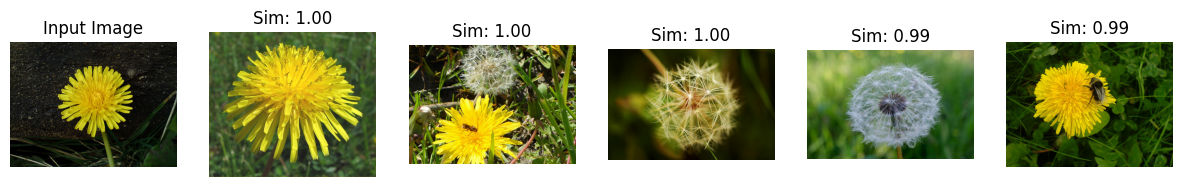

In [18]:
def display_results(input_img_path, top_sim):
    plt.figure(figsize=(15, 5))
    
    # Отображение входного изображения
    plt.subplot(1, 6, 1)
    input_image = Image.open(input_img_path)
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis("off")

    for i, (image_path, similarity) in enumerate(top_sim):
        plt.subplot(1, 6, i + 2)
        similar_image = Image.open(image_path)
        plt.imshow(similar_image)
        plt.title(f"Sim: {similarity:.2f}")
        plt.axis("off")
    
    plt.show()

display_results(inp_image, top_similar_images)

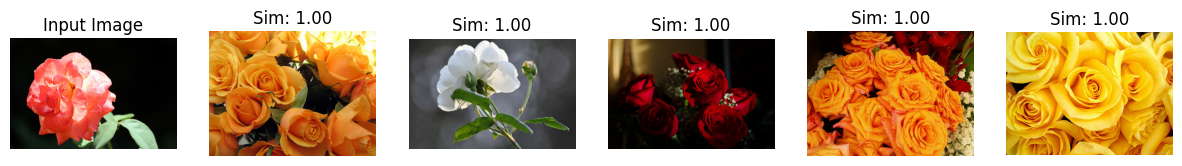

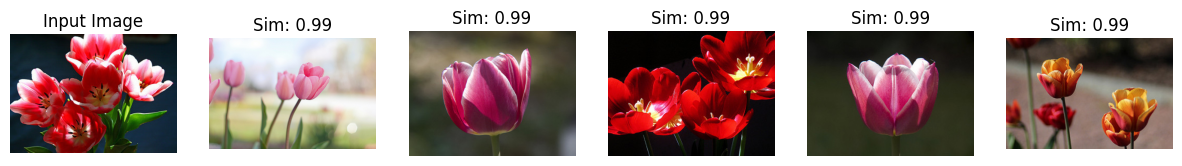

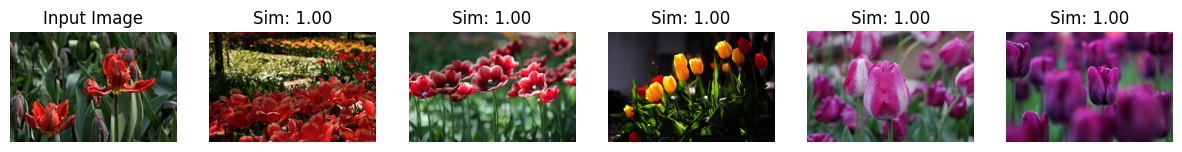

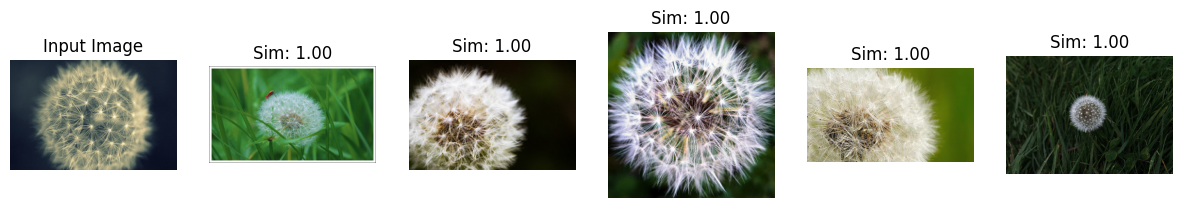

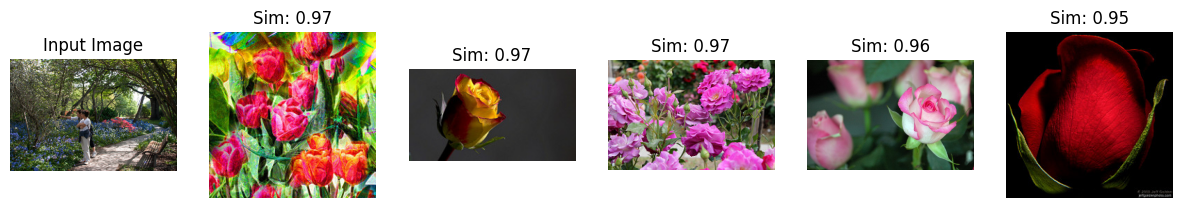

In [27]:
import random

# Выбор случайных изображений
random_test_images = random.sample(list(df_val["image_path"]), 5)

# Показ результатов
for image_path in random_test_images:
    input_embedding = get_embedding(image_path, model, transform)
    top_similar_images = find_top_similar_images(input_embedding, embeddings)
    display_results(image_path, top_similar_images)

# Save Model

In [28]:
torch.save(model.state_dict(), "model.pth")